In [10]:
import numpy as np
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import sem
import seaborn as sns
import pickle
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone


sns.set_theme(style='white',font_scale=1.5)

In [ ]:
def shuffle_spikes(X, min_shift=20):
    X_shuff = np.zeros(X.shape)
    for i in range(X.shape[-1]):
        X_shuff[:,i] = np.roll(X[:,i], np.random.choice(
            np.arange(min_shift, X.shape[-1])))
    return X_shuff

<div class="alert alert-block alert-info"> <b>NOTE</b> Use blue boxes for Tips and notes. </div>


In [2]:
data = np.load('../../../../data/raw_data/nike_calcium_trace.npy')
X = data.T
Xt = data.T
with open('../../../../data/raw_data/behaviour.pickle','rb') as f:
    behaviour = pickle.load(f)

In [3]:
behaviour.keys()

dict_keys(['sampling_rate', 'offset', 'sound1', 'sound2', 'sound3', 'sound4', 'sound5', 'sound6', 'iti'])

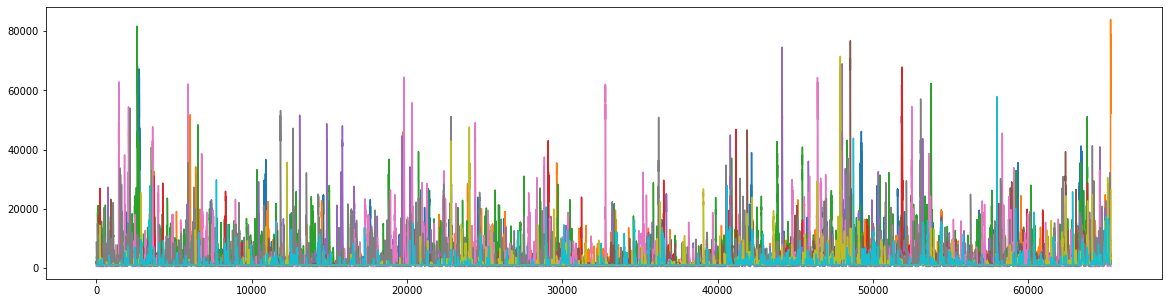

In [4]:
plt.figure(figsize=(20,5))
for i in range(10):
    plt.plot(X[:,i])

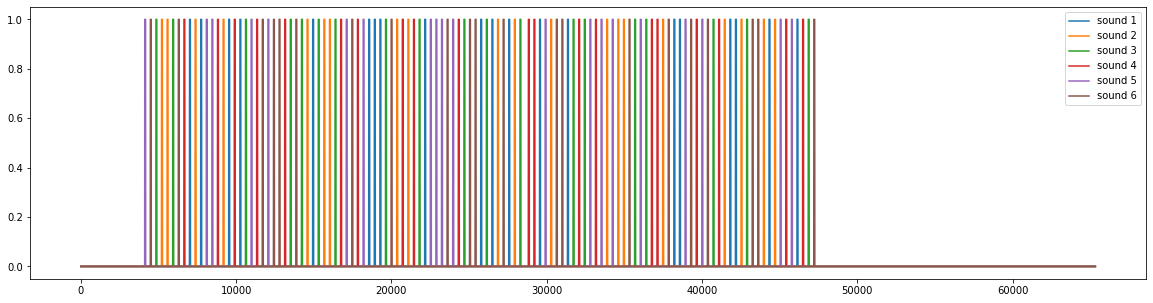

In [5]:
stimulus_duration = 60 # in indexes
stimuli = [1,2,3,4,5,6]

plt.figure(figsize=(20,5))
y = np.zeros(X.shape[0])
for s in stimuli:
    stim_mask = np.zeros(X.shape[0])
    for onset in behaviour[f'sound{s}']:
        stim_mask[onset:onset+stimulus_duration] = 1
        y[onset:onset+stimulus_duration] = s
    plt.plot(stim_mask,label=f'sound {s}')

plt.legend()

## Stimulus classification, all trial together
- Seven labels: each of the six stimuli + non stimulus period
- Slightly unbalanced: non stimulus is a bit longer
- Non-evenly distributed: use stratified kfold + shuffling

In [6]:

logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1,C=1000)
scaler = StandardScaler()
classifier = Pipeline(steps=[("scaler",scaler), ("logistic", logistic)])


kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
performance = []
shuffled_performance = []

for i,(train_index, test_index) in enumerate(kf.split(X,y)):
    print(f'fold {i+1}/{n_splits}')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # LR classifier
    split_classifier = clone(classifier)
    split_classifier.fit(X_train, y_train)

    y_pred = split_classifier.predict(X_test)
    performance.append(f1_score(y_test,y_pred,average='weighted'))    

    # shuffled baseline
    shuffled_performance.append(f1_score(y_test,np.random.permutation(y_test),average='weighted'))

NameError: name 'n_splits' is not defined

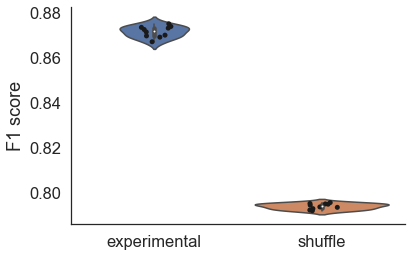

In [17]:
sns.set(style='white',font_scale=1.5)
sns.stripplot(data=[performance,shuffled_performance],color='k')
sns.violinplot(data=[performance,shuffled_performance])
plt.xticks([0,1],labels=['experimental','shuffle']);
plt.ylabel('F1 score')
sns.despine()

# Stimulus specific component
Decoding the six stimuli all together, without non stimulus periods

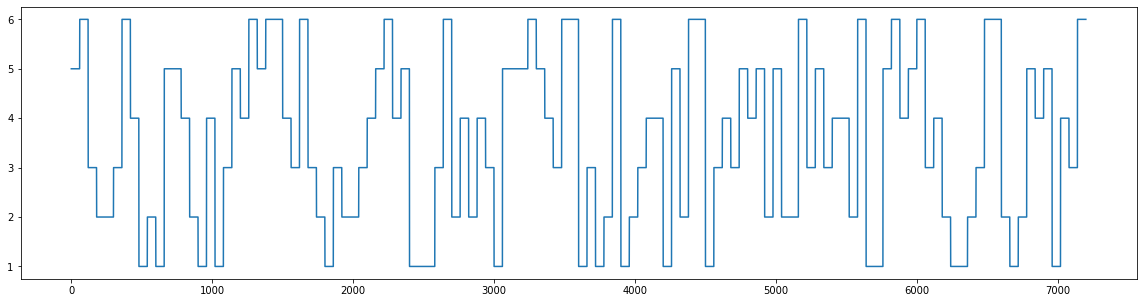

In [7]:
stimulus_only = True # use only stimulus periods

data = np.load('../../../../data/raw_data/nike_calcium_trace.npy')
X_all = data.T
with open('../../../../data/raw_data/behaviour.pickle','rb') as f:
    behaviour = pickle.load(f)

stimulus_duration = 60 # in indexes
stimuli = [1,2,3,4,5,6]

plt.figure(figsize=(20,5))
y_all = np.zeros(X_all.shape[0])
for s in stimuli:
    stim_mask = np.zeros(X_all.shape[0])
    for onset in behaviour[f'sound{s}']:
        stim_mask[onset:onset+stimulus_duration] = 1
        y_all[onset:onset+stimulus_duration] = s
    
# isolate stimuli periods   
if stimulus_only: 
    X = X_all[y_all>0]
    y = y_all[y_all>0]
else:
    X = X_all
    y = y_all

plt.plot(y)

In [8]:
n_splits = 10
n_shuff = 10

logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1,C=1000)
scaler = StandardScaler()
classifier = Pipeline(steps=[("scaler",scaler), ("logistic", logistic)])


kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
performance = []
shuffled_performance = []
models = []

for i,(train_index, test_index) in enumerate(kf.split(X,y)):
    print(f'fold {i+1}/{n_splits}')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # LR classifier
    split_classifier = clone(classifier)
    split_classifier.fit(X_train, y_train)

    y_pred = split_classifier.predict(X_test)
    performance.append(f1_score(y_test,y_pred,average='weighted')) 
    for _ in range(n_shuff):
        shuffled_performance.append(f1_score(y_test,np.random.permutation(y_test),average='weighted'))
    models.append(split_classifier)

best_model = models[np.argmax(performance)]



fold 1/10
fold 2/10
fold 3/10
fold 4/10
fold 5/10
fold 6/10
fold 7/10
fold 8/10
fold 9/10
fold 10/10


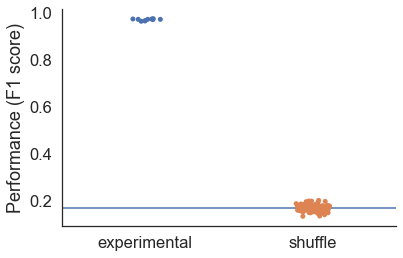

In [18]:
sns.stripplot(data=[performance,shuffled_performance])
plt.axhline(y=1.0/6.0,label='expected chance level')
plt.xticks([0,1],labels=['experimental','shuffle'])
plt.ylabel('Performance (F1 score)')
sns.despine()


In [20]:
lr = best_model['logistic']
weights = lr.coef_

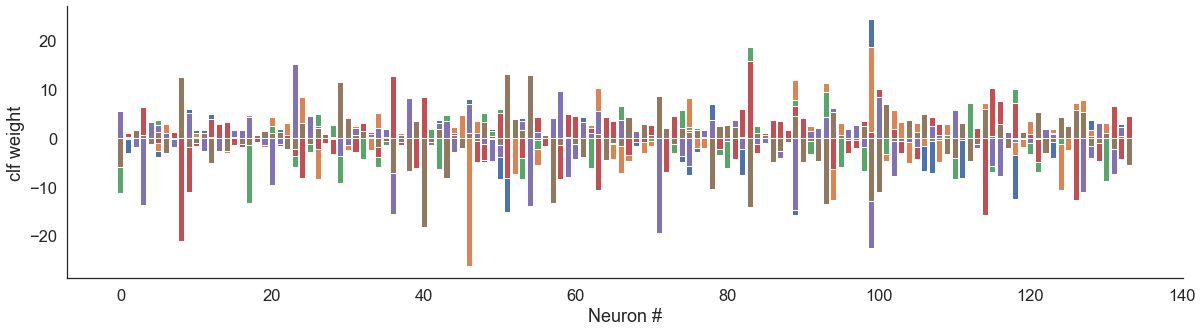

In [22]:
plt.figure(figsize=(20,5))
for i,w in enumerate(weights):
    plt.bar(np.arange(len(w)),w,label=f'stim {i+1}')

plt.xlabel("Neuron #")
plt.ylabel("clf weight")

sns.despine()

## stimulus dependent activity

In [103]:
scaler = StandardScaler()
scaled_X  = scaler.fit_transform(X)
ensemble_activity = scaled_X @weights.T

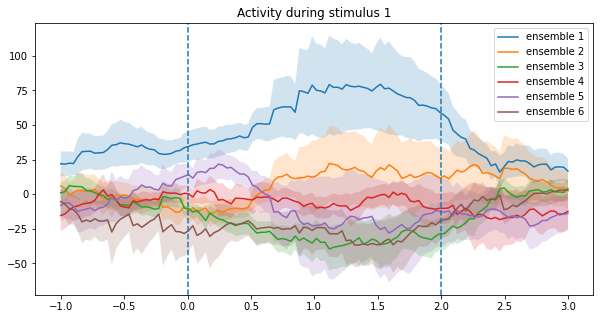

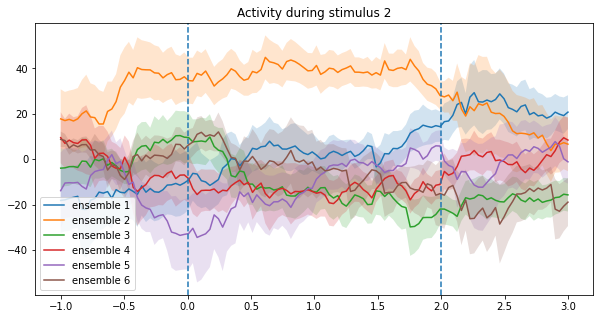

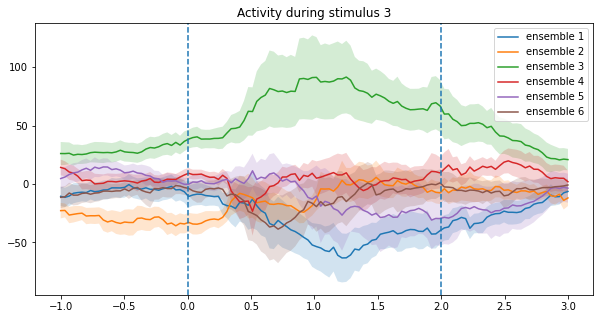

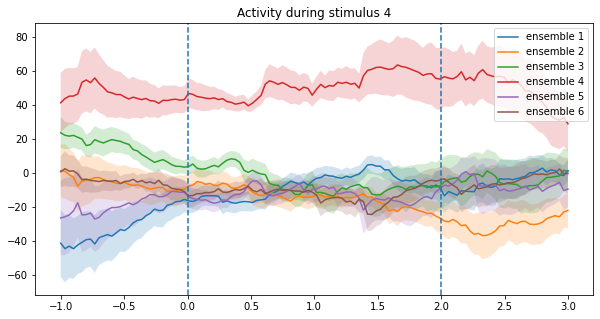

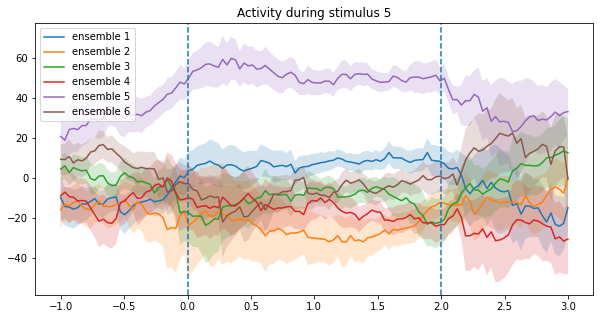

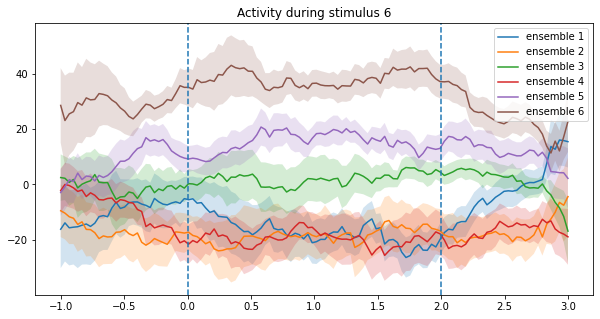

In [104]:
from scipy.stats import sem

scaler = StandardScaler()
X_scaled  = scaler.fit_transform(X_all)

for stimulus in stimuli:

    ensamble_mat = []
    for onset in behaviour[f'sound{stimulus}']:
            X_stim = X_scaled[onset-30:onset+stimulus_duration+30]
            ensemble_activity = X_stim @ weights.T
            ensamble_mat.append(ensemble_activity)
    ensamble_mat = np.asarray(ensamble_mat)

    avg_activity = np.mean(ensamble_mat,axis=0)
    std_activity = sem(ensamble_mat,axis=0)
    plt.figure(figsize=(10,5))
    plt.title(f'Activity during stimulus {stimulus}')
    for i in range(avg_activity.shape[-1]):
        time = np.linspace(-1,3,avg_activity.shape[0])
        plt.plot(time,avg_activity[:,i],label=f'ensemble {i+1}')
        plt.fill_between(time,avg_activity[:,i]-std_activity[:,i],avg_activity[:,i]+std_activity[:,i],alpha=0.2)
        plt.legend()

    plt.axvline(x=0,linestyle='--')
    plt.axvline(x=2,linestyle='--')